In [1]:
# %pip install rasterio
# %pip install geopandas
# %pip install fiona
# %pip install earthpy


import numpy as np
import numpy.ma as ma
#from matplotlib import pyplot as plt
import rasterio
import geopandas as gpd
#import rasterstats as rs
#from IPython.display import display
import pandas as pd
import os
import fiona
import rasterio.mask
#import matplotlib.pyplot as plt
import warnings
import rasterio
import rasterio.features
warnings.filterwarnings('ignore') #don't display warnings
from rasterio.mask import mask
#import earthpy.plot as ep
import cv2
import datetime
from tqdm.auto import tqdm

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
root_file = 'C:\\Users\\leoag\\Michigan State University\\MSU Dry Bean Breeding Lab - General\\UAS_Beans\\2022\\SVREC_Mat'
shp_file = "2022_SVREC_Shp_Plots_final01.shp"
img_dir= f"{root_file}/"'b._Orthomosaics'
shp_dir = f"{root_file}/"'c._Shapefiles'
plot_dir = f"{root_file}/"'e._ClipPlots_BN_512_128'
ground_dir = f"{root_file}/"'d._Ground_notes'

#os.chdir('/content/drive/MyDrive/temp_roi')

#plots_img = '/plots_img'

# try:
#     os.mkdir(plot_dir)
# except:
#   pass
# os.chdir(img_dir)
# # Print the current working directory
# print("Current working directory: {0}".format(os.getcwd()))
#DIR_TEST = f'{DIR_INPUT}/test'
plots = gpd.read_file(f'{shp_dir}' f'/{shp_file}')

plots_names=list(plots.columns.values)
print(plots_names)

['fid_1', 'PlotID', 'Global_ID', 'Plot', 'ENTRY', 'REP', 'Rng', 'Pas', 'Name', 'Identity1', 'Pedigree', 'Experiment', 'Origin', 'Selection', 'Descriptio', 'Year', 'Location', 'Planter', 'Harvester', 'IBLK', 'geometry']


In [4]:
shp_file_info=fiona.open(f'{shp_dir}/'f'{shp_file}', "r") 
#first feature of the shapefile
shp_file_inf = shp_file_info.next()
print(shp_file_inf)

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('fid_1', 1.0), ('PlotID', '34'), ('Global_ID', '2216_1036'), ('Plot', '1036'), ('ENTRY', '36'), ('REP', '1'), ('Rng', '12'), ('Pas', '125'), ('Name', 'R20627'), ('Identity1', None), ('Pedigree', 'R17605/R16503'), ('Experiment', '2216'), ('Origin', '18R623-03-02'), ('Selection', '19-20T1497'), ('Descriptio', '18A0623-18L611-18-19T1968-19T1719-19-20T1497'), ('Year', '2022'), ('Location', 'SVREC'), ('Planter', '1624'), ('Harvester', '2276'), ('IBLK', None)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(281577.12208533555, 4808367.105865113), (281577.13648992963, 4808367.905735421), (281581.1358414635, 4808367.83371245), (281581.12143686943, 4808367.033842144), (281577.12208533555, 4808367.105865113)]]}}


In [5]:
img_list = os.listdir(img_dir)
img_list = [v for v in img_list if v.endswith('.tif')]
print(img_list)

['07_20_2022_SVREC_RGB.tif', '08_18_2022_SVREC_RGB.tif', '08_20_2022_SVREC_RGB.tif', '08_23_2022_SVREC_RGB.tif', '08_26_2022_SVREC_RGB.tif', '08_30_2022_SVREC_RGB.tif', '09_02_2022_SVREC_RGB.tif', '09_05_2022_SVREC_RGB.tif', '09_08_2022_SVREC_RGB.tif', '09_13_2022_SVREC_RGB.tif', '09_16_2022_SVREC_RGB.tif']


In [6]:
# Create an empty list to store the img names
img_list_names = []

for l in range(len(img_list)):
    print(l)
    img_list_names.append(str(img_list[l]))

print(img_list_names)

0
1
2
3
4
5
6
7
8
9
10
['07_20_2022_SVREC_RGB.tif', '08_18_2022_SVREC_RGB.tif', '08_20_2022_SVREC_RGB.tif', '08_23_2022_SVREC_RGB.tif', '08_26_2022_SVREC_RGB.tif', '08_30_2022_SVREC_RGB.tif', '09_02_2022_SVREC_RGB.tif', '09_05_2022_SVREC_RGB.tif', '09_08_2022_SVREC_RGB.tif', '09_13_2022_SVREC_RGB.tif', '09_16_2022_SVREC_RGB.tif']


In [7]:
plot_num_field_name = "Global_ID"
trial_name = "SVREC"
planting_date = '06.01.2021'

width = 512 #256
height = 128 #64

In [8]:
# Create an empty list to store DOY from the image names
img_DOY_list = []

for l in range(len(img_list)):
    img_DOY = str(img_list[l]) 
    ts = img_DOY[0:10]
    ts = ts.replace('_', '.')
    fmt = '%m.%d.%Y'

    dt = datetime.datetime.strptime(ts, fmt)
    tt = dt.timetuple()
    tt = tt.tm_yday

    pl = planting_date
    dt2 = datetime.datetime.strptime(pl, fmt)
    tt2 = dt2.timetuple()
    tt2 = tt2.tm_yday

    tt_f = str(tt-tt2).zfill(3)

    img_DOY_list.append(tt_f)

print(img_DOY_list)

['049', '078', '080', '083', '086', '090', '093', '096', '099', '104', '107']


In [9]:
ground_df = pd.read_csv(f"{ground_dir}/"'22_SVREC_BN_ground.csv', usecols=(0,1)).astype(str)
#ground_df= ground_df.astype(str)
ground_list = []

for value in ground_df["Global_ID"]:
    ground_list.append(value)

ground_list

['22011001',
 '22011002',
 '22011003',
 '22011004',
 '22011005',
 '22011006',
 '22011007',
 '22011008',
 '22011009',
 '22011010',
 '22011011',
 '22011012',
 '22011013',
 '22011014',
 '22011015',
 '22011016',
 '22011017',
 '22011018',
 '22011019',
 '22011020',
 '22011021',
 '22011022',
 '22011023',
 '22011024',
 '22011025',
 '22011026',
 '22011027',
 '22011028',
 '22011029',
 '22011030',
 '22011031',
 '22011032',
 '22011033',
 '22011034',
 '22011035',
 '22011036',
 '22012001',
 '22012002',
 '22012003',
 '22012004',
 '22012005',
 '22012006',
 '22012007',
 '22012008',
 '22012009',
 '22012010',
 '22012011',
 '22012012',
 '22012013',
 '22012014',
 '22012015',
 '22012016',
 '22012017',
 '22012018',
 '22012019',
 '22012020',
 '22012021',
 '22012022',
 '22012023',
 '22012024',
 '22012025',
 '22012026',
 '22012027',
 '22012028',
 '22012029',
 '22012030',
 '22012031',
 '22012032',
 '22012033',
 '22012034',
 '22012035',
 '22012036',
 '22013001',
 '22013002',
 '22013003',
 '22013004',
 '22013005',

In [10]:
if len(ground_list) == len(plots):
    print('Data set has the same lenght to ground and aerial plot numbers')
    print(len(ground_list))
    print(len(plots))

else:
    print('Data set do not merge with ground and aerial plot numbers')
    print(len(ground_list))
    print(len(plots))
    

# len(ground_list)
# len(plots)

Data set do not merge with ground and aerial plot numbers
636
1812


In [11]:
for tiffile in tqdm(img_list_names):
    print(tiffile)

    ts = tiffile[0:10]
    ts = ts.replace('_', '.')
    fmt = '%m.%d.%Y'
    dt = datetime.datetime.strptime(ts, fmt)
    tt = dt.timetuple()
    tt = tt.tm_yday
    pl = planting_date
    dt2 = datetime.datetime.strptime(pl, fmt)
    tt2 = dt2.timetuple()
    tt2 = tt2.tm_yday
    DOY = str(tt-tt2).zfill(3)
    
    noPlot_list = []
    # Plot_ID_list = []
    with fiona.open(f'{shp_dir}/'f'{shp_file}', "r") as shapefile:
    
        for feature in tqdm(shapefile):
            
            Plot_ID = feature["properties"][plot_num_field_name]
            Plot_ID = Plot_ID.replace('_', '')
            # [k for k in ground_list if Plot_ID in k]  
                      
            if Plot_ID in ground_list:
                shape = [feature["geometry"]]
                # Plot_ID_list.append(Plot_ID)
                        
            # Change the current working directory
                os.chdir(img_dir)
                
                with rasterio.open(tiffile, "r") as ras:
                    out_image, out_transform = mask(ras, shape, crop=True, nodata=0)
                    out_meta = ras.meta
                    
                    out_image = ma.masked_where(out_image == 0, out_image)
                    out_image = ma.filled(out_image.astype(float), np.nan)
                    
                # Change the current working directory
                    os.chdir(f'{plot_dir}')

                    new_img_name = trial_name + '_' + Plot_ID + '_' +  DOY + '.png'
                    
                    out_meta.update({"driver": "PNG",
                    "height": height,
                    "width": width,
                    "transform": out_transform})
                    
                    with rasterio.open(new_img_name, "w", **out_meta) as dest:
                        dest.write(out_image)
                        #print(new_img_name) 

            else:
                noPlot_list.append(Plot_ID)
                pass  

  0%|          | 0/11 [00:00<?, ?it/s]

07_20_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

08_18_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

08_20_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

08_23_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

08_26_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

08_30_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

09_02_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

09_05_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

09_08_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

09_13_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

09_16_2022_SVREC_RGB.tif


  0%|          | 0/1812 [00:00<?, ?it/s]

In [12]:
noPlot_ID_list = pd.DataFrame(noPlot_list, columns=['Plots'])
noPlot_ID_list
#noPlot_ID_list.to_csv('C:\\Users\\leoag\\Michigan State University\\MSU Dry Bean Breeding Lab - General\\UAS_Beans\\2020\\SVREC_Mat\\f._codes\\noPlot.csv')

,Plots
0,22161036
1,22161035
2,22161034
3,22161031
4,22161032
...,...
1171,22132003
1172,22132004
1173,22162001
1174,22162002


In [13]:
#ep.plot_rgb(out_image, rgb=[0, 1, 2], title="Red Green Blue", stretch=True)

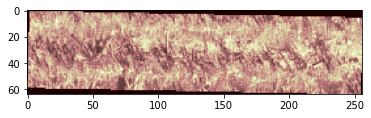

In [14]:
#plotting
from matplotlib import pyplot
with rasterio.open(new_img_name) as src:
    pyplot.imshow(src.read(1), cmap='pink')
    pyplot.show()